In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import regex as re
import jieba
import networkx as nx
from itertools import combinations
from tqdm import tqdm
import pickle

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data mining/2020-01.csv')

In [ ]:
stopwords = set()
with open('/content/drive/MyDrive/data mining/baidu_stopwords.txt', 'r', encoding='utf-8') as file:
    for line in file:
        stopwords.add(line.strip())

In [ ]:
df = df[df['content'].str.contains('女', na=False)][['user_id', 'content']]

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
df

user_id                                            content
0       74003a81d4afb8ab  按惯例最后一天的总结微博 2019 旅游大年mark一笔 春节➡️埃及 清明➡️武隆 五一➡...
1       a75d4827920520fe  #疫苗挽救生命# 今天，我们又收获了两个重要的好消息：中国国家药品监督管理局批准了厦门万泰沧...
2       9df3be38f28d153d  女人这辈子最幸福的大概是有个好家庭嫁个好老公生个健康宝宝有个好公婆没有负债花钱自由真幸运目前...
3       a53900bd8166b99b                #武汉发现不明原因肺炎#女人不要贪慕虚荣。虚荣是一剂毒药，而且会上瘾。
4       abb53ea80f0c8ce9  2019年底很多行内人提及了结婚率，这方面欧美和日本应该可以例证。如果一样的话也就意味着低结...
...                  ...                                                ...
306319  3ebaa5eaea8d5207  【心疼！这是#22岁感染科护士的手#[泪]】#周刊君与你共同战疫# 胡佩是湖南省儿童医院感染...
306320  6ca5373140a6adc9  【心疼！这是#22岁感染科护士的手#[泪]】#周刊君与你共同战疫# 胡佩是湖南省儿童医院感染...
306321  f3d121c555f55ff7  #湖北省委书记回应一床难求#我不知道现在的武汉这样的情况还有多少。。。 【一家三口疑似新冠肺...
306322  64767b8053fe3987  #韩红爱心驰援武汉##抗击新型肺炎我们在行动# 0131项目实时进展[加油] 转发理由://...
306323  376bb87322eafc64  【心疼！这是#22岁感染科护士的手#[泪]】#周刊君与你共同战疫# 胡佩是湖南省儿童医院感染...

[306324 rows x 2 columns]

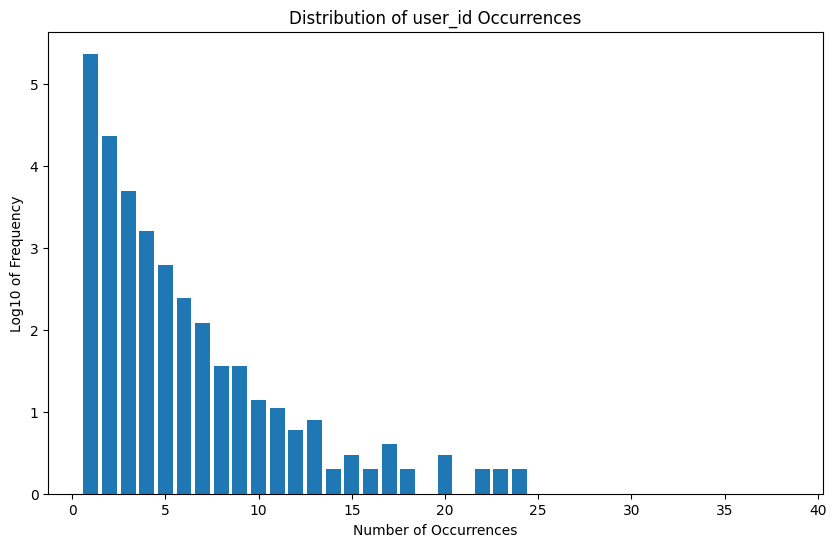

In [ ]:
user_id_counts = df['user_id'].value_counts()
distribution = user_id_counts.value_counts().sort_index()
log_distribution = np.log10(distribution.values)
plt.figure(figsize=(10, 6))
plt.bar(distribution.index, log_distribution)
plt.xlabel("Number of Occurrences")
plt.ylabel("Log10 of Frequency")
plt.title("Distribution of user_id Occurrences")
plt.show()

In [ ]:
distribution_summary = {
    'Total Unique user_ids': [user_id_counts.count()],
    'Mean': [user_id_counts.mean()],
    'Median': [user_id_counts.median()],
    'Standard Deviation': [user_id_counts.std()],
    'Minimum': [user_id_counts.min()],
    'Maximum': [user_id_counts.max()],
    'Total user_id Occurrences': [user_id_counts.sum()]
}

distribution_summary_df = pd.DataFrame(distribution_summary)
distribution_summary_df

Total Unique user_ids      Mean  Median  Standard Deviation  Minimum  \
0                 262739  1.165887     1.0            0.580498        1   

   Maximum  Total user_id Occurrences  
0       38                     306324

Approximately it takes several days to iterate over the whole dataset, so we only include those users with at least 3 posts here.

In [ ]:
threshold = 3
df = df[df['user_id'].isin(user_id_counts[user_id_counts >= threshold].index)]

In [ ]:
df

user_id                                            content
3       a53900bd8166b99b                #武汉发现不明原因肺炎#女人不要贪慕虚荣。虚荣是一剂毒药，而且会上瘾。
9       2bbad0c0f929a302                 #武汉发现不明原因肺炎#女人，不要记性太好。回忆越多的女人幸福越少。
18      3f5b21e11e3c2ba3  #武汉发现不明原因肺炎#女人有百千回妩媚，亿万次风情。而女人无论是哪一种美丽都源于女人对自己的爱。
65      760b0c6c1c956fe5  北京朝阳医院为高龄女患者孙某某提供正常且必要的医疗服务：2019年12月27日15时许，患者...
74      92d798413493a3b6  临床资料由急慢性腹泻引起的小儿红臀56例,男30例,女26例;年龄为生后6d~2岁。临床表现...
...                  ...                                                ...
306288  27348d5d11fbf063  #韩红爱心驰援武汉##抗击新型肺炎我们在行动# 0131项目实时进展[加油] 转发理由:#正...
306296  8f1e3eaa2fbc8c4b  【心疼！这是#22岁感染科护士的手#[泪]】#周刊君与你共同战疫# 胡佩是湖南省儿童医院感染...
306298  da80a2f52fe36854  #专家呼吁把N95口罩留给医护人员#平和的[困]女人，要求不是那么多，不会动不动就嫉妒别人的...
306299  f63bda16a5c40d21  【心疼！这是#22岁感染科护士的手#[泪]】#周刊君与你共同战疫# 胡佩是湖南省儿童医院感染...
306307  b0c08336ffe43ac8  #韩红爱心驰援武汉##抗击新型肺炎我们在行动# 0131项目实时进展[加油] 转发理由://...

[28056 rows x 2 columns]

In [ ]:
df['tokens'] = df['content'].apply(lambda x: ''.join(re.findall(r'[\u4e00-\u9fa5]', x)))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in jieba.cut(x) if word not in stopwords and len(word) > 1])
df

<ipython-input-11-a7decde6f8ca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens'] = df['content'].apply(lambda x: ''.join(re.findall(r'[\u4e00-\u9fa5]', x)))
Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.738 seconds.
DEBUG:jieba:Loading model cost 0.738 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.
<ipython-input-11-a7decde6f8ca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

user_id                                            content  \
3       a53900bd8166b99b                #武汉发现不明原因肺炎#女人不要贪慕虚荣。虚荣是一剂毒药，而且会上瘾。   
9       2bbad0c0f929a302                 #武汉发现不明原因肺炎#女人，不要记性太好。回忆越多的女人幸福越少。   
18      3f5b21e11e3c2ba3  #武汉发现不明原因肺炎#女人有百千回妩媚，亿万次风情。而女人无论是哪一种美丽都源于女人对自己的爱。   
65      760b0c6c1c956fe5  北京朝阳医院为高龄女患者孙某某提供正常且必要的医疗服务：2019年12月27日15时许，患者...   
74      92d798413493a3b6  临床资料由急慢性腹泻引起的小儿红臀56例,男30例,女26例;年龄为生后6d~2岁。临床表现...   
...                  ...                                                ...   
306288  27348d5d11fbf063  #韩红爱心驰援武汉##抗击新型肺炎我们在行动# 0131项目实时进展[加油] 转发理由:#正...   
306296  8f1e3eaa2fbc8c4b  【心疼！这是#22岁感染科护士的手#[泪]】#周刊君与你共同战疫# 胡佩是湖南省儿童医院感染...   
306298  da80a2f52fe36854  #专家呼吁把N95口罩留给医护人员#平和的[困]女人，要求不是那么多，不会动不动就嫉妒别人的...   
306299  f63bda16a5c40d21  【心疼！这是#22岁感染科护士的手#[泪]】#周刊君与你共同战疫# 胡佩是湖南省儿童医院感染...   
306307  b0c08336ffe43ac8  #韩红爱心驰援武汉##抗击新型肺炎我们在行动# 0131项目实时进展[加油] 转发理由://...   

                                                   tokens  
3          [武汉, 发现, 不明, 原因, 肺炎, 女人, 贪慕虚荣, 虚荣, 一剂, 毒药, 上瘾]  
9        [武汉, 发现, 不明, 原因, 肺炎, 女人, 记性, 太好, 回忆, 越多, 女人, 幸福]  
18      [武汉, 发现, 不明, 原因, 肺炎, 女人, 百千, 妩媚, 亿万, 风情, 女人, 无...  
65      [北京朝阳医院, 高龄, 女患者, 某某, 提供, 医疗, 服务, 年月日时, 患者, 某某...  
74      [临床, 资料, 急慢性, 腹泻, 小儿, 臀例, 男例, 女例, 年龄, 为生, 后岁, ...  
...                                                   ...  
306288  [韩红, 爱心, 驰援, 武汉, 抗击, 新型, 肺炎, 项目, 实时, 进展, 加油, 转...  
306296  [心疼, 感染, 护士, 手泪, 周刊, 战疫, 胡佩是, 湖南省, 儿童医院, 感染, 护...  
306298  [专家, 呼吁, 口罩, 留给, 医护人员, 平和, 女人, 动不动, 嫉妒, 别人, 富贵...  
306299  [心疼, 感染, 护士, 手泪, 周刊, 战疫, 胡佩是, 湖南省, 儿童医院, 感染, 护...  
306307  [韩红, 爱心, 驰援, 武汉, 抗击, 新型, 肺炎, 项目, 实时, 进展, 加油, 转...  

[28056 rows x 3 columns]

In [ ]:
def jaccard_similarity(tokens1, tokens2):
    set1 = set(tokens1)
    set2 = set(tokens2)
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union) if len(union) != 0 else 0

In [ ]:
gamma_low = 0.4
gamma_high = 1

G = nx.Graph()

for user_id in df['user_id']:
    G.add_node(user_id)

In [ ]:
df_grouped = df.groupby('user_id')['tokens'].apply(lambda x: sum(x, [])).reset_index()

In [ ]:
df_grouped

user_id                                             tokens
0     000e4db9ddce427b  [武汉市, 自发, 退票, 远游, 害怕, 传染源, 不想, 添麻烦, 专家, 呼吁, 武汉...
1     00116138d520baf8  [对症, 中药, 治愈, 北京, 新型, 肺炎, 患者, 首都, 健康, 北京, 今日, 有...
2     001902e6ccd0a645  [广西, 新增, 新型, 肺炎, 确诊, 病例, 广西, 累计, 新型, 肺炎, 确诊, 病...
3     002ade9e0ace18d4  [湖北, 不止, 武汉, 武汉, 重灾区, 周边地区, 防疫, 情况, 重视, 周边, 疫情...
4     003299655db0000d  [广东, 确诊, 新型, 肺炎, 病例, 广东, 累计, 确诊, 新型, 肺炎, 截至, 我...
...                ...                                                ...
7611  ffe1e4a840b2607f  [韩国, 武汉, 肺炎, 确诊, 病例, 平和, 女人, 动不动, 嫉妒, 别人, 富贵, ...
7612  ffe5f9e4617882e4  [分享, 普通外科, 口罩, 正确, 佩戴, 方式, 普通外科, 口罩, 能防, 飞沫传染,...
7613  ffe94787da7a5603  [武汉, 市民, 朋友, 一封信, 武汉, 女子, 低烧, 咳嗽, 利用, 退烧药, 降温,...
7614  ffe9e84ecb214659  [请战, 新型, 肺炎, 武汉, 女医生, 现代版, 夫书, 此事, 告知, 明昌, 告诉,...
7615  ffef60050d085dab  [新加坡, 确认, 首例, 新型, 冠状病毒, 病例, 新加坡, 卫生部, 今晚, 确认, ...

[7616 rows x 2 columns]

In [ ]:
to_remove = set()

for (index1, row1), (index2, row2) in tqdm(combinations(df_grouped.iterrows(), 2), desc="Processing pairs"):
    id1, tokens1 = row1['user_id'], row1['tokens']
    id2, tokens2 = row2['user_id'], row2['tokens']
    if id1 in to_remove or id2 in to_remove:
        continue
    similarity = jaccard_similarity(tokens1, tokens2)
    if similarity >= gamma_high:
        to_remove.add(id2)
        continue
    if similarity >= gamma_low:
        G.add_edge(id1, id2)

Processing pairs: 28997920it [31:52, 15165.38it/s]


Exclude isolated points.

In [ ]:
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)

In [ ]:
plt.figure(figsize=(80, 80))
pos = nx.spring_layout(G)

<Figure size 8000x8000 with 0 Axes>

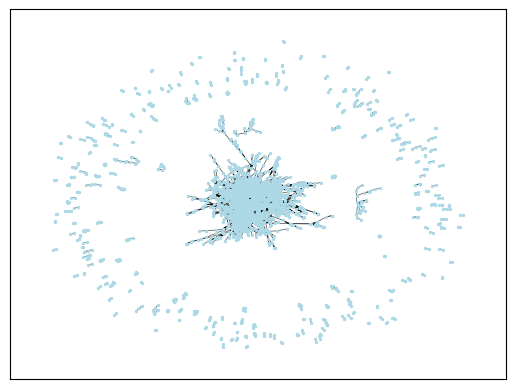

In [ ]:
nx.draw_networkx_nodes(G, pos, node_size=2, node_color='lightblue')
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.7)

plt.show()

In [ ]:
pickle.dump(G, open('/content/drive/MyDrive/data mining/graph.pickle', 'wb'))

Let's check the largest connected subgraph.

In [ ]:
largest_component = max(nx.connected_components(G), key=len)
G_largest = G.subgraph(largest_component).copy()

In [ ]:
pickle.dump(G_largest, open('/content/drive/MyDrive/data mining/largest_subgraph.pickle', 'wb'))

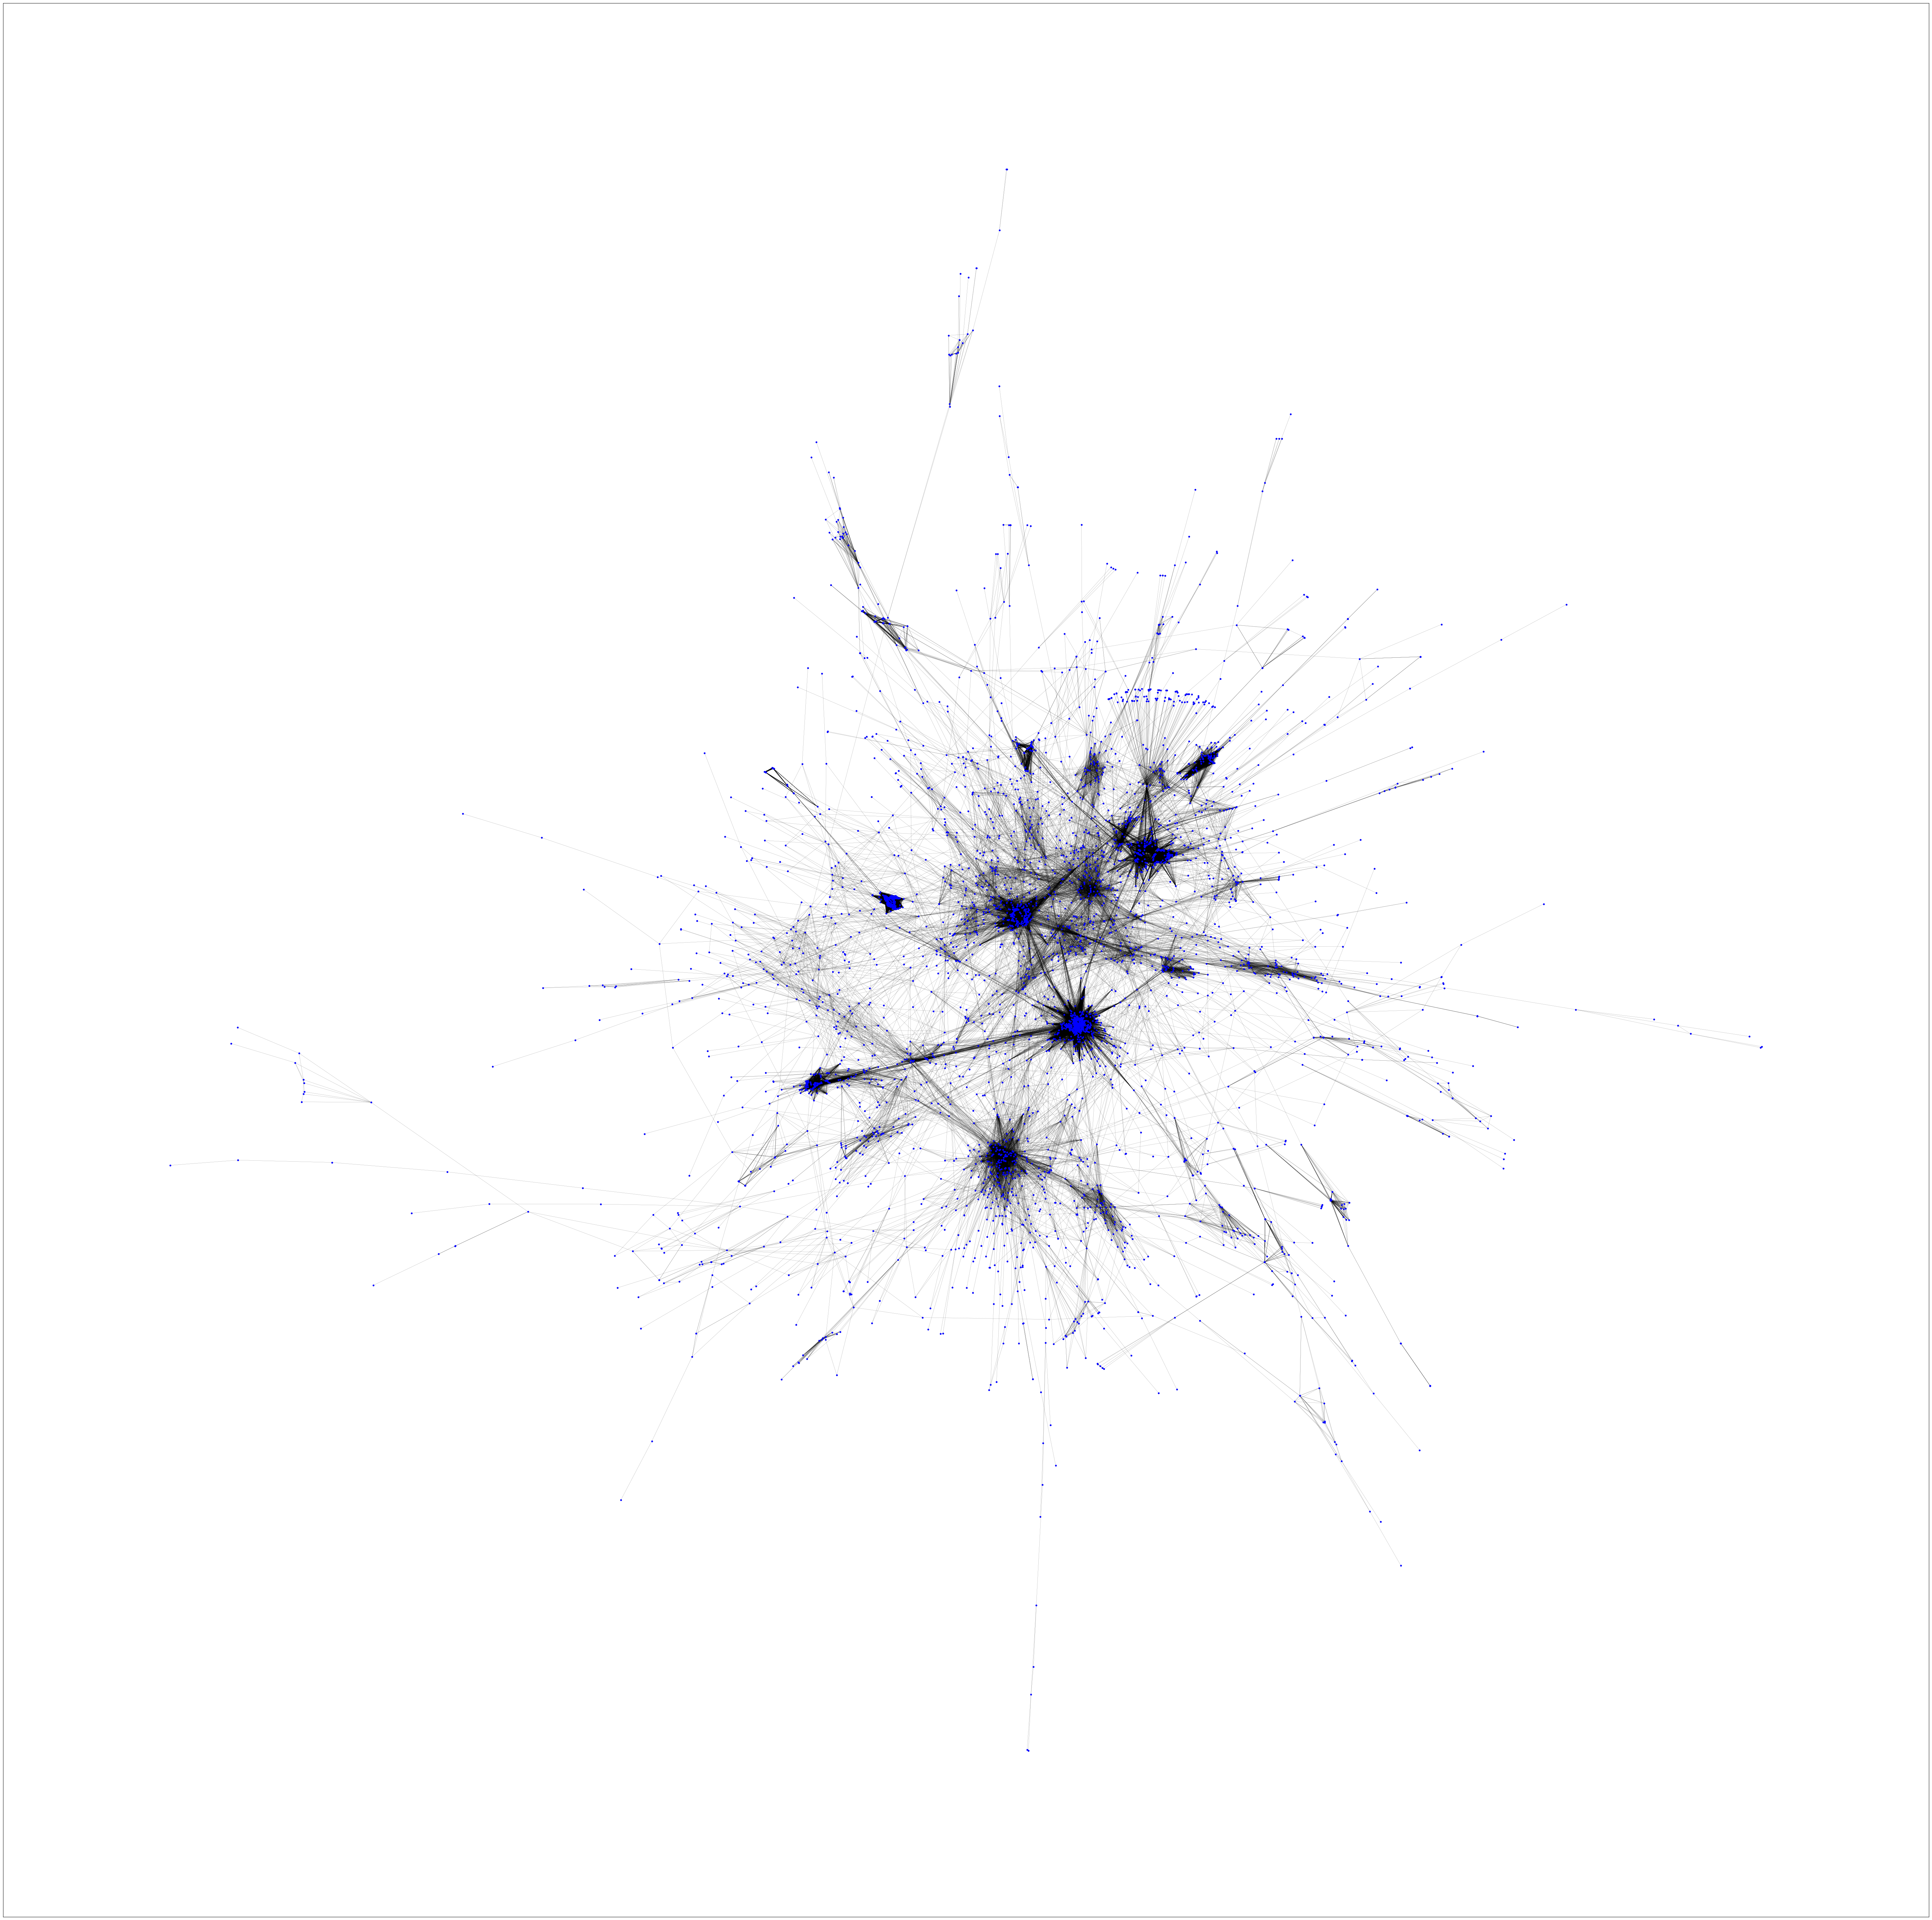

In [ ]:
plt.figure(figsize=(80, 80))
pos = nx.spring_layout(G_largest)

nx.draw_networkx_nodes(G_largest, pos, node_size=10, node_color='blue')
nx.draw_networkx_edges(G_largest, pos, width=0.2, alpha=0.7)

plt.show()

In [ ]:
connected_components = sorted(nx.connected_components(G), key=len, reverse=True)
second_largest_component = connected_components[1]
G_second_largest = G.subgraph(second_largest_component).copy()

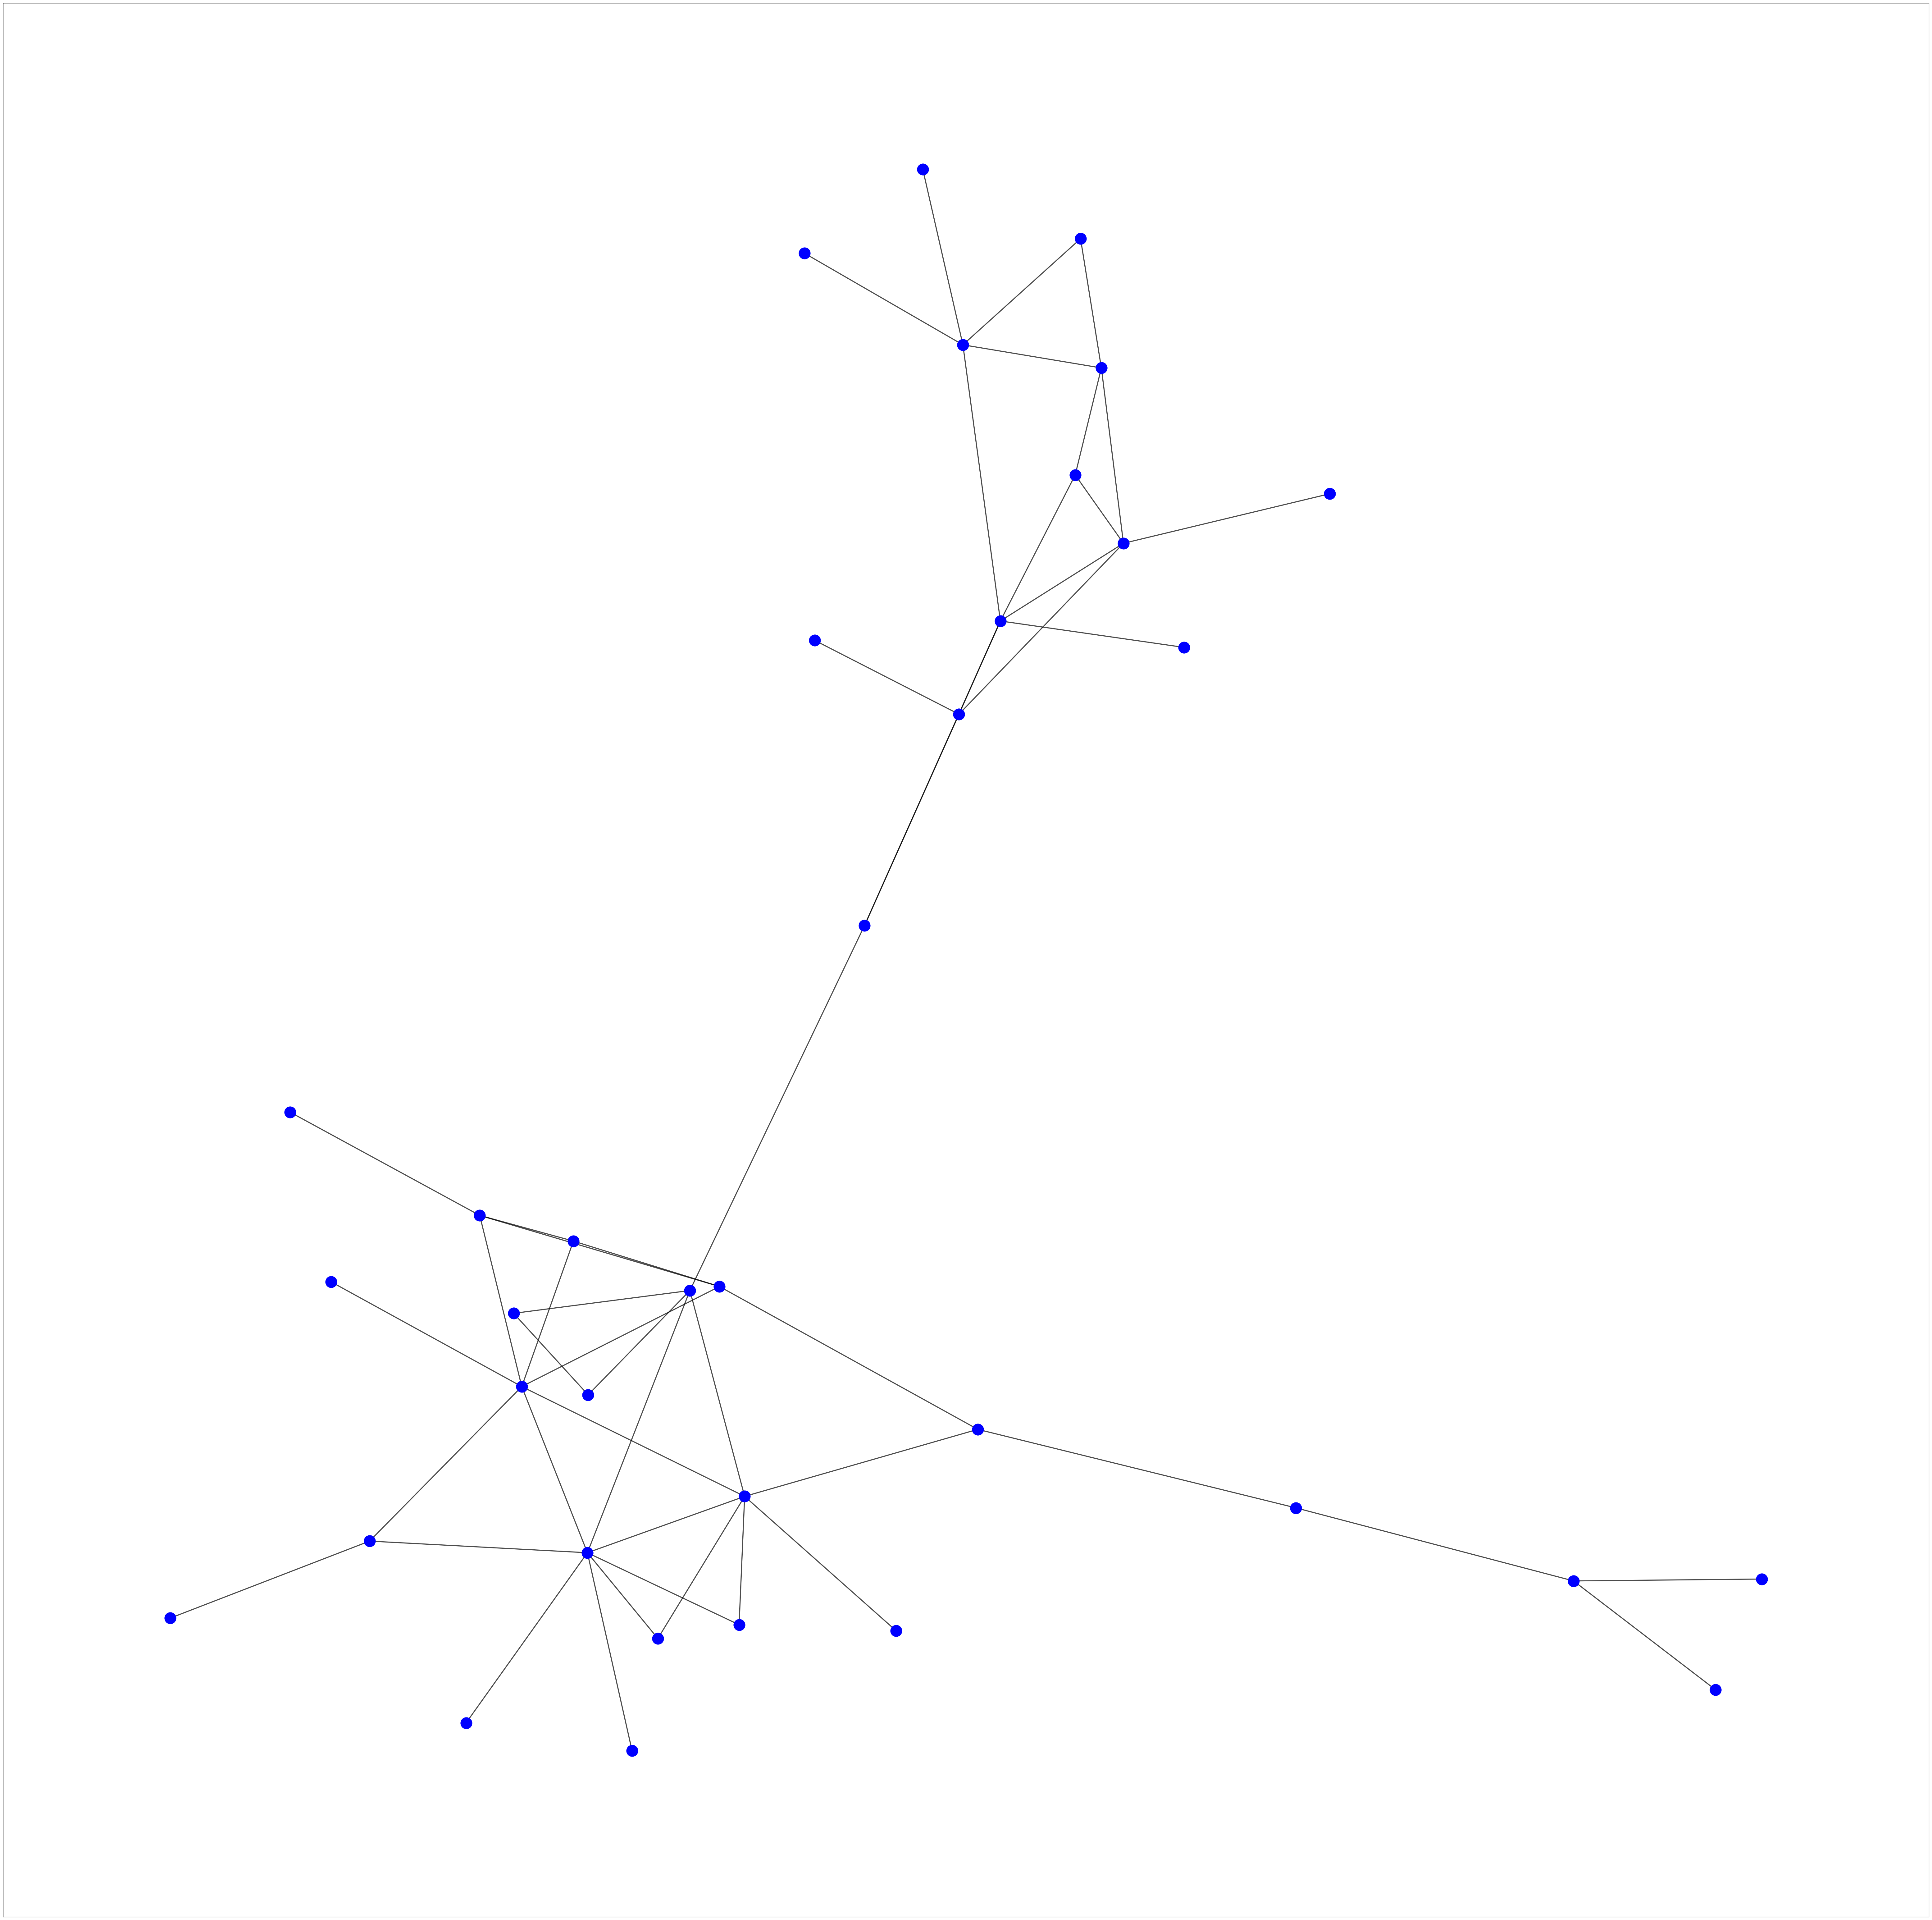

In [ ]:
plt.figure(figsize=(80, 80))
pos = nx.spring_layout(G_second_largest)

nx.draw_networkx_nodes(G_second_largest, pos, node_size=700, node_color='blue')
nx.draw_networkx_edges(G_second_largest, pos, width=2.5, alpha=0.7)

plt.show()